In [2]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet,VGG16
from keras.layers import Dense
from rembg import remove
from keras.models import Model
from tqdm import tqdm

In [3]:
def enhance_image(image):
  # Load the input image
  input_image = Image.open(image)
  plt.imshow(input_image)

  # remove background
  output_image = remove(input_image, alpha_matting=True)

  # Create a black background of the same size as the input image
  black_background = Image.new('RGB', input_image.size, (0, 0, 0))

  if black_background.size != output_image.size:
    # Resize one of the images to match the dimensions of the other
    black_background = black_background.resize(output_image.size)

  if black_background.mode != output_image.mode:
    # Convert one of the images to the same mode as the other
    black_background = black_background.convert(output_image.mode)

  # Composite the foreground object onto the black background
  composite_image = Image.alpha_composite(black_background.convert('RGBA'), output_image)

  # Convert the PIL Image to a NumPy array
  composite_np = np.array(composite_image)

    # Convert to BGR (OpenCV format)
  bgr = cv2.cvtColor(composite_np, cv2.COLOR_RGBA2BGR)

  hsv_img = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
  h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]

  clahe = cv2.createCLAHE(clipLimit = 10.0, tileGridSize = (20,20))
  v = clahe.apply(v)
  hsv_img = np.dstack((h,s,v))
  rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)


  bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

  gamma = 1.5

  # Perform gamma correction
  gamma_corrected = np.power(bgr / 255.0, gamma)
  
  gamma_corrected = np.uint8(gamma_corrected * 255)
  final_output = cv2.cvtColor(gamma_corrected, cv2.COLOR_BGR2RGB)

  return final_output

792 ms ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


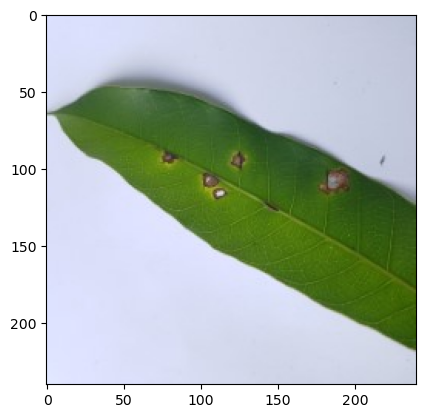

In [4]:
%timeit enhance_image('./20211011_133406 (Custom).jpg')

In [8]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import local_binary_pattern
from skimage.feature import hog

In [9]:
def process_image(image_path, image_size=32):
    """
    Reads, resizes, and preprocesses a grayscale contour image.
    Extracts features including flattened pixels, LBP, Hu Moments, and HOG.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    # Resize image to a fixed size (32x32)
    image_resized = cv2.resize(image, (image_size, image_size))
    image_normalized = image_resized / 255.0  # Normalize pixel intensities

    # Flattened pixel intensities
    flat_features = image_normalized.flatten()

    # Convert to uint8 for LBP and HOG
    image_uint8 = (image_normalized * 255).astype(np.uint8)

    # Extract Local Binary Pattern (LBP) features
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(image_uint8, n_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    lbp_hist_normalized = lbp_hist.astype("float") / lbp_hist.sum()

    # Extract Hu Moments (shape-based features)
    moments = cv2.moments(image_normalized)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Extract HOG features (captures shape and texture)
    hog_features, _ = hog(image_uint8, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                          block_norm='L2-Hys', visualize=True)

    # Concatenate all features (pixels, LBP, Hu Moments, HOG)
    combined_features = np.concatenate([flat_features, lbp_hist_normalized, hu_moments, hog_features])

    return combined_features


In [10]:
%timeit process_image('./20211011_133406 (Custom).jpg')

2.24 ms ± 54.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
